#Wejście i wyjście

na wejściu jest zdjęcie ukazujące jakiś rodzaj zmiany skórnej, a na wyjściu jest prawdopodobieństwo należenia do każdej z klas (łagodna vs złośliwa)

Zdjęcia są ładowane bezpośrednio z folderu do obiektu tensorflow Dataset, a dane są z trzech kanałów RGB. Próbowałem używać również danych, które zostały przerobione na grayscale zamiast trzech kanałów, ale wyniki były bardzo słabe. Jak widać kolor zmiany skórnej ma ogromne znaczenie do rozpoznawania jej charakteru. Rozmiar pojedynczego zdjęcia wybrałem na 150x150. Próbowałem innych rozmiarów, jednak dawały gorsze rezultaty. Ostatecznie przeprowadziłem grid search i rozmiar 150x150 daje najlepsze rezultaty.  Dane są batchowane po 32, więc ostatecznie jedna paczka danych wejściowych ma rozmiar (32,150,150,3)



#Lokalizacja Danych:
Dane wziąłem z Kaggle, są to zdjęcia dwóch rodzajów nowotworowych zmian skórnych, łagodnych i złośliwych, link do danych: https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign. Dane są ładowane z githuba (początkowo były ładowane z google drive, jednak trwało to znacznie dłużej). Utworzyłem publiczne repozytorium i tam wrzuciłem dane, a w notatniku jest link pobierający całe dane. Nie trzeba nic pobierać specjalnie, wszystko odbywa się na poziomie notatnika.

#Architektura sieci:

Ostateczny model to konwolucyjna sieć neuronowa składająca się z następujących warstw:

                      #conv block
                      tf.keras.layers.Conv2D(16,(4),padding = 'same',activation = 'relu'),
                      tf.keras.layers.MaxPooling2D(2),
                      tf.keras.layers.Conv2D(32,(4),padding = 'same',activation = 'relu'),
                      tf.keras.layers.MaxPooling2D(2),
                      tf.keras.layers.Conv2D(64,(4),padding = 'same',activation = 'relu'),
                      tf.keras.layers.MaxPooling2D(2),
                      tf.keras.layers.Conv2D(128,(4),padding = 'same',activation = 'relu'),
                      tf.keras.layers.MaxPooling2D(2),
                      tf.keras.layers.Conv2D(256,(4),padding = 'same',activation = 'relu'),
                      tf.keras.layers.MaxPooling2D(2),
                      #fully connected
                      tf.keras.layers.Flatten(),
                      tf.keras.layers.Dense(128,activation = 'relu'),
                      tf.keras.layers.Dropout(0.2),
                      tf.keras.layers.Dense(256,activation = 'relu'),
                      tf.keras.layers.Dropout(0.3),
                      tf.keras.layers.Dense(1, activation = 'sigmoid')

Jak widać są tu warstwy Conv2D i MaxPooling2D, jak również warstwy sieci połączone na koniec sieci. Wypracowanie tej architektury zajęło sporo czasu, ale daje ona całkiem dobre rezultaty (~88% accuracy). Początkowe sieci dawały wyniki na poziomie 77-81% accuracy.

In [44]:
#importing the required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, roc_auc_score, confusion_matrix
import pandas as pd
import tensorflow.keras as keras
import time


In [54]:
#defining all the required functions to be able to run the model

def create_Dataset(root_path, image_size=(224,224), batch_size = 32):


  print('Loading Dataset...')
  #loading the data using tensorflow functions, because they are very well optimized
  dataset = tf.keras.utils.image_dataset_from_directory(
    root_path,
    image_size=(image_size),
    batch_size=batch_size)
  print('Dataset loaded')

  #preprocessing
  normalization_layer = tf.keras.layers.Rescaling(1./255)
  def preprocess(image,label):
        image = normalization_layer(image)
        # image = tf.image.rgb_to_grayscale(image)  # this results in way worse accuracies, I tried that and it worked really bad
        return image, label


  #returning normalized dataset
  return dataset.map(preprocess)

#calculate reading speed
def reading_benchmark(dataset):
  t1_start = time.perf_counter()
  for item in dataset.take(int(dataset.cardinality().numpy())):
    time.sleep(1E-12)
  t1_stop = time.perf_counter()
  print(f'elapsed time: { round(t1_stop - t1_start)}s')

#plot exemplary data
def plotData(dataset):
    #taking one batch of data
    for images, labels in dataset.take(1):
        images = images.numpy()
        labels = labels.numpy()
        break

    idx = np.random.choice(len(images), size=4, replace=False)

    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    for i,ax in enumerate(axes.flatten()):
        ax.imshow(images[idx[i]])
        ax.set_title(f"Label: {'Malignant' if labels[idx[i]] else 'benign'}")
        ax.axis("off")

    plt.show()

#function to plot the changes in accuracy and loss function during training
def plotTrainHistory(history):
  fig,ax = plt.subplots(3,1, figsize = (7,7))
  ax[0].plot(history.history['loss'], label = 'train')
  ax[0].plot(history.history['val_loss'], label = 'val')
  ax[0].legend()
  ax[0].set_title('loss history')

  ax[1].plot(history.history['loss'], label = 'train')
  ax[1].plot(history.history['val_loss'], label = 'val')
  ax[1].set_yscale('log')
  ax[1].legend()
  ax[1].set_title('loss history (logarithmic)')

  ax[2].plot(history.history['accuracy'], label = 'train')
  ax[2].plot(history.history['val_accuracy'], label = 'val')
  ax[2].legend()
  ax[2].set_title('accuracy history')

#function to plot 4 images and their predictions right or wrong depending on the parameter wrongClassified
def plot4(dataset, wrongClassified = False):
  fig,ax = plt.subplots(2,2, figsize = (7,7))

  x,y_true = tuple(zip(*dataset.unbatch()))

  x = np.array(x)
  y_true = np.array(y_true)

  print(x.shape)
  y_pred = model.predict(dataset)
  y_pred = y_pred.reshape(-1)
  y_pred = (y_pred >= 0.5).astype(int)

  if wrongClassified:
    idx = np.where(y_pred != y_true)[0]
  else:
    idx = np.where(y_pred == y_true)[0]

  idx = np.random.choice(idx, size=4, replace=False)
  print

  for i,ax in enumerate(ax.flatten()):
    ax.imshow(x[idx[i]])
    ax.set_title(f'Predicted value:{y_pred[idx[i]]}, True value:{y_true[idx[i]]}')

#split dataset into train and test functions
def split_dataset(dataset, test_fraction=0.2,buffer_size=1000, seed=None):
    dataset = dataset.shuffle(buffer_size=buffer_size, seed=seed, reshuffle_each_iteration=False)

    total_count = dataset.cardinality().numpy()


    test_size = int(test_fraction * total_count)
    test_dataset = dataset.take(test_size)
    train_dataset = dataset.skip(test_size)

    return train_dataset, test_dataset

In [3]:
#Downloading data located on github
!wget https://github.com/radekgersz/ML2_data/archive/refs/heads/main.zip
!unzip main.zip


--2025-06-12 13:34:52--  https://github.com/radekgersz/ML2_data/archive/refs/heads/main.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/radekgersz/ML2_data/zip/refs/heads/main [following]
--2025-06-12 13:34:53--  https://codeload.github.com/radekgersz/ML2_data/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [        <=>         ] 162.31M  17.9MB/s    in 9.1s    

2025-06-12 13:35:02 (17.9 MB/s) - ‘main.zip’ saved [170199077]

Archive:  main.zip
01c1c065d819155621062f9ee9f5d50fb31faf67
   creating: ML2_data-main/
   creating: ML2_data-main/benign/
  inflating: ML

#Creating the Dataset

In [48]:
#loading the dataset from folder
t_start = t1_start = time.perf_counter()
dataset = create_Dataset('/content/ML2_data-main', image_size = (150,150))

print(f'elapsed time: {round(time.perf_counter() - t_start,2)}s')

Loading Dataset...
Found 3297 files belonging to 2 classes.
Dataset loaded
elapsed time: 0.2s


In [55]:
#going through all the data
reading_benchmark(dataset)

elapsed time: 3s


# Plotting exemplary input images

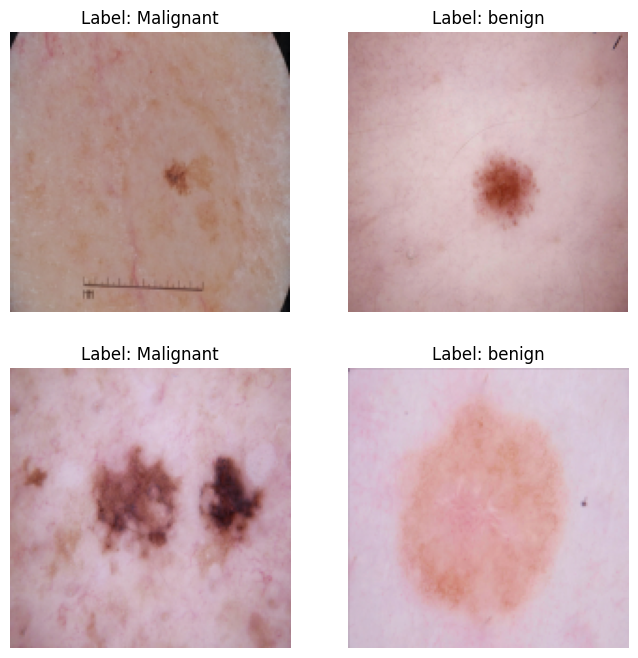

In [41]:
plotData(dataset)

# Splitting Dataset into train and test

In [20]:
train_dataset, test_dataset = split_dataset(dataset,test_fraction=0.2,buffer_size=1000,seed=42)
train_dataset,test_dataset = train_dataset.prefetch(tf.data.AUTOTUNE).cache(), test_dataset.prefetch(tf.data.AUTOTUNE).cache()

# Counting the Labels for Original Dataset

In [21]:
label_counts_train = {"0":0, "1":0}
for _, labels in train_dataset:
    for label in labels.numpy():
        label_counts_train[str(int(label))] += 1

label_counts_test = {"0":0,"1":0}
for _, labels in test_dataset:
    for label in labels.numpy():
        label_counts_test[str(int(label))] += 1

table = pd.DataFrame(data = {'Train': [label_counts_train['0'],label_counts_train['1']], 'Test': [label_counts_test['0'], label_counts_test['1']]})

print('Label Count for Original Dataset')
print(table)


Label Count for Original Dataset
   Train  Test
0   1451   345
1   1206   295


#Data augmentation

In [22]:
#defining augmentation layers
rotation_layer = tf.keras.layers.RandomRotation(0.7, fill_mode='reflect', interpolation='bilinear', seed=None)
flip_layer = tf.keras.layers.RandomFlip("horizontal")

ds_transformed = train_dataset.map(lambda x, y: (rotation_layer(x), y))
ds_transformed = ds_transformed.map(lambda x, y: (flip_layer(x), y))

# Combine original and augmented datasets
train_dataset = train_dataset.concatenate(ds_transformed)

ds_transformed = ds_transformed.map(lambda x, y: (rotation_layer(x), y))
ds_transformed = ds_transformed.map(lambda x, y: (flip_layer(x), y))

train_dataset = train_dataset.concatenate(ds_transformed)

ds_transformed = ds_transformed.map(lambda x, y: (rotation_layer(x), y))
ds_transformed = ds_transformed.map(lambda x, y: (flip_layer(x), y))

train_dataset = train_dataset.concatenate(ds_transformed)

# Counting the Labels for Augmented Dataset

In [8]:
label_counts_train = {"0":0, "1":0}
for _, labels in train_dataset:
    for label in labels.numpy():
        label_counts_train[str(int(label))] += 1

label_counts_test = {"0":0,"1":0}
for _, labels in test_dataset:
    for label in labels.numpy():
        label_counts_test[str(int(label))] += 1

table = pd.DataFrame(data = {'Train': [label_counts_train['0'],label_counts_train['1']], 'Test': [label_counts_test['0'], label_counts_test['1']]})

print('Label Count for Augmented Dataset')
print(table)

Label Count for Augmented Dataset
   Train  Test
0   5752   325
1   4876   315


# Model definition and training

In [23]:
model = tf.keras.Sequential(layers = [tf.keras.Input(shape=(150,150,3)),
                      #conv block
                      tf.keras.layers.Conv2D(16,(4),padding = 'same',activation = 'relu'),
                      tf.keras.layers.MaxPooling2D(2),
                      tf.keras.layers.Conv2D(32,(4),padding = 'same',activation = 'relu'),
                      tf.keras.layers.MaxPooling2D(2),
                      tf.keras.layers.Conv2D(64,(4),padding = 'same',activation = 'relu'),
                      tf.keras.layers.MaxPooling2D(2),
                      tf.keras.layers.Conv2D(128,(4),padding = 'same',activation = 'relu'),
                      tf.keras.layers.MaxPooling2D(2),
                      tf.keras.layers.Conv2D(256,(4),padding = 'same',activation = 'relu'),
                      tf.keras.layers.MaxPooling2D(2),
                      #fully connected
                      tf.keras.layers.Flatten(),
                      tf.keras.layers.Dense(128,activation = 'relu'),
                      tf.keras.layers.Dropout(0.2),
                      tf.keras.layers.Dense(256,activation = 'relu'),
                      tf.keras.layers.Dropout(0.3),
                      tf.keras.layers.Dense(1, activation = 'sigmoid')
                          ]
                          )
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=500,
    decay_rate=0.95,
    staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                loss=tf.keras.losses.BinaryCrossentropy()
,metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4,min_delta=0.01, verbose=0)

history = model.fit(train_dataset.skip(100),
                  epochs=20,
                  verbose=1,
                  validation_data = train_dataset.take(100),
                  callbacks = [callback]
                  )
model.evaluate(test_dataset)


Epoch 1/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.6624 - loss: 0.5911 - val_accuracy: 0.7951 - val_loss: 0.3955
Epoch 2/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 48s 197ms/step - accuracy: 0.7857 - loss: 0.4404 - val_accuracy: 0.8196 - val_loss: 0.3740
Epoch 3/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 81s 194ms/step - accuracy: 0.8146 - loss: 0.3897 - val_accuracy: 0.8206 - val_loss: 0.3658
Epoch 4/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 47s 196ms/step - accuracy: 0.8147 - loss: 0.3790 - val_accuracy: 0.8177 - val_loss: 0.3559
Epoch 5/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 47s 195ms/step - accuracy: 0.8300 - loss: 0.3592 - val_accuracy: 0.7999 - val_loss: 0.3836
Epoch 6/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 47s 195ms/step - accuracy: 0.8328 - loss: 0.3453 - val_accuracy: 0.8174 - val_loss: 0.3458
Epoch 7/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 47s 195ms/step - accuracy: 0.8418 - loss: 0.3351 - val_accuracy: 0.8563 - val_loss: 0.3098
Epoch 8/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 47s 192ms/step - accuracy: 0.8504 - loss: 0

[0.2755182385444641, 0.8812500238418579]

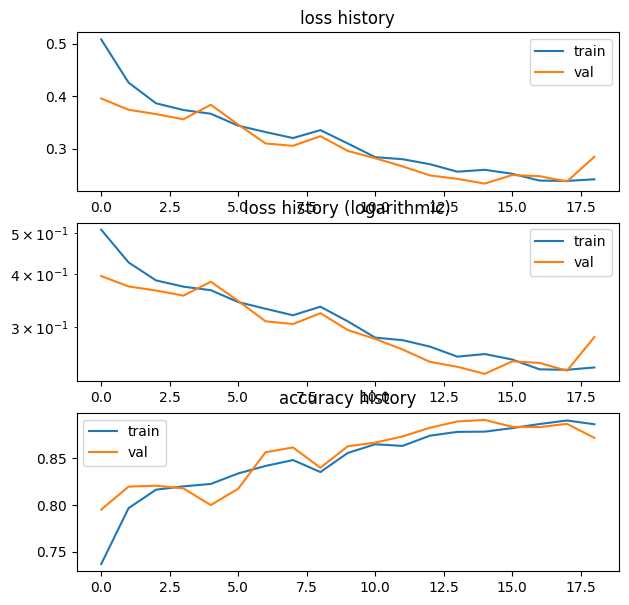

In [42]:
plotTrainHistory(history)

#Result analysis and evalutation

In [24]:
#simple evalutation of the model's accuracy
model.evaluate(test_dataset)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8832 - loss: 0.2755


[0.2755182385444641, 0.8812500238418579]

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


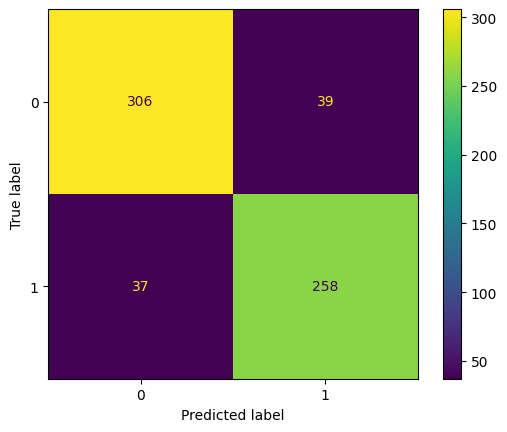

In [25]:
#creating a confusion matrix
y = np.array(tuple(zip(*test_dataset.unbatch()))[1])
y_pred_prob = model.predict(test_dataset)
y_pred_prob = y_pred_prob.reshape(-1)
y_pred = (y_pred_prob >= 0.5).astype(int)


ConfusionMatrixDisplay.from_predictions(y,y_pred)


In [31]:
#creating a table showcasing model accuracy on different data
cm = confusion_matrix(y,y_pred)

total_labels_0 = label_counts_train['0'] + label_counts_test['0']
total_labels_1 = label_counts_train['1'] + label_counts_test['1']

labels = [0,1]
total_Labels = [total_labels_0, total_labels_1]
training_data = [label_counts_train['0'], label_counts_train['1']]
test_data = [label_counts_test['0'],label_counts_test['1']]
correct_predictions = [cm[0][0], cm[1][1]]
final_accuracies = [cm[0][0]/(cm[0][1]+cm[0][0]),cm[1][1]/(cm[1][0]+cm[1][1])]
final_recalls = [cm[0][0]/(cm[0][0] + cm[0][1]), cm[1][1]/(cm[1][1] + cm[0][1])]
table_final = pd.DataFrame({'Label': labels, 'Total Data': total_Labels, 'Training Data': training_data, 'Test Data': test_data, 'Correct predictions':correct_predictions, 'Accuracy': final_accuracies, 'Recall': final_recalls})

print(table_final)

   Label  Total Data  Training Data  Test Data  Correct predictions  Accuracy  \
0      0        1796           1451        345                  306  0.886957   
1      1        1501           1206        295                  258  0.874576   

     Recall  
0  0.886957  
1  0.868687  


In [36]:
#calculating auc
auc = round(roc_auc_score(y,y_pred_prob),3)

print('auc:', auc)

auc: 0.957


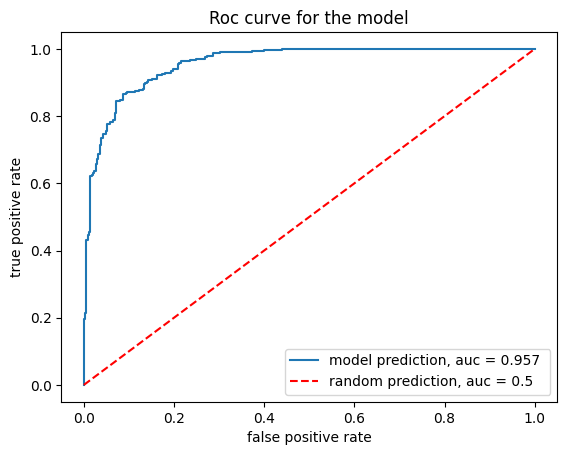

In [38]:
#roc curve
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
plt.plot(fpr,tpr, label = f'model prediction, auc = {auc} ')
plt.plot([0,1], '--', color = 'red', label = 'random prediction, auc = 0.5')
plt.title('Roc curve for the model')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()

#Plotting examples the model got right

(640, 150, 150, 3)
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


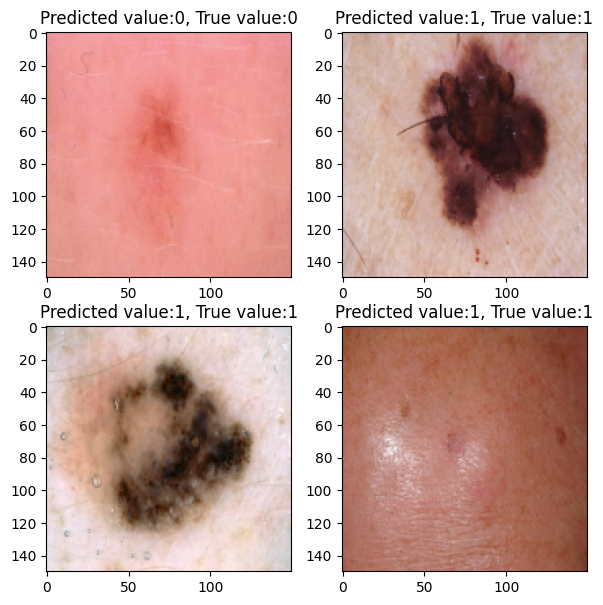

In [29]:
plot4(test_dataset,wrongClassified=False)

#Plotting examples the model got wrong

(640, 150, 150, 3)
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


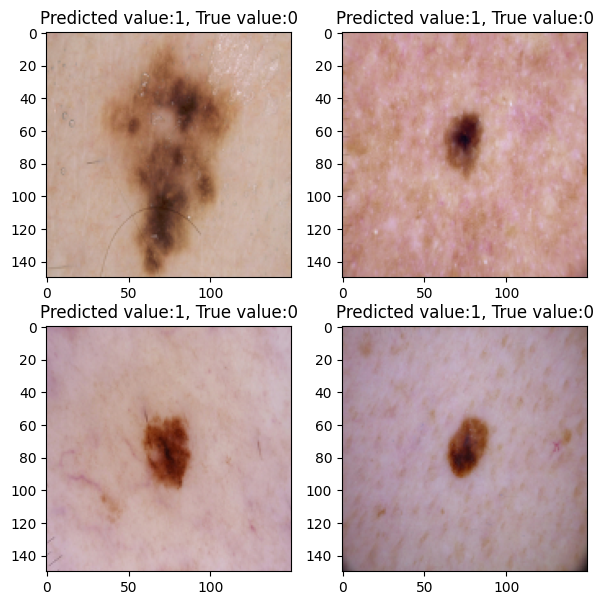

In [30]:
plot4(test_dataset,wrongClassified=True)